# Roman configurations

In [9]:
import numpy as np
import os
import matplotlib.pyplot as plt
import slsim
from slsim.lens_pop import LensPop
from slsim.Observations.roman_speclite import configure_roman_filters
from slsim.Observations.roman_speclite import filter_names
from slsim.Plots.lens_plots import LensingPlots
import speclite
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
import corner

%matplotlib inline

In [2]:
# Import default Roman Space Telescope configuration
path = os.path.dirname(slsim.__file__)
module_path, _ = os.path.split(path)
skypy_config = os.path.join(module_path, "data/SkyPy/roman-like.yml")

# generate Roman filters
configure_roman_filters()

# import filter bands and make them recogniable in speclite
roman_filters = filter_names()
# filters are ['Roman-F062', 'Roman-F087', 'Roman-F106', 'Roman-F129', 'Roman-F158', 'Roman-F184', 'Roman-F146', 'Roman-F213']

speclite.filters.load_filters(
    roman_filters[0],
    roman_filters[1],
    roman_filters[2],
    roman_filters[3],
    roman_filters[4],
    roman_filters[5],
    roman_filters[6],
    roman_filters[7],
)

In [3]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# define a sky area
sky_area = Quantity(value=0.5, unit="deg2")


# define limits in the intrinsic deflector and source population (in addition to the skypy config file)
kwargs_deflector_cut = {"band": "F062", "band_max": 25, "z_min": 0.01, "z_max": 3.0}
kwargs_source_cut = {"band": "F062", "band_max": 28, "z_min": 0.01, "z_max": 5.0}


# run skypy pipeline and make galaxy-galaxy population class
lens_pop = LensPop(
    deflector_type="all-galaxies",
    source_type="galaxies",
    kwargs_deflector_cut=kwargs_deflector_cut,
    kwargs_source_cut=kwargs_source_cut,
    kwargs_mass2light=None,
    skypy_config=skypy_config,
    sky_area=sky_area,
    cosmo=cosmo,
)

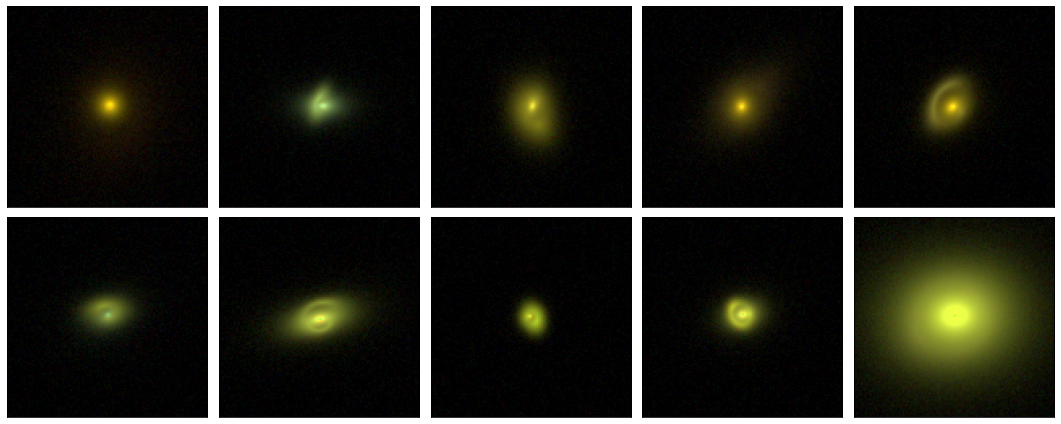

In [4]:
kwargs_lens_cut_plot = {
    "min_image_separation": 0.5,
    "max_image_separation": 10,
    "mag_arc_limit": {"F158": 21, "F106": 21, "F062": 21},
}

# make montage of realizations
gg_plot = LensingPlots(lens_pop, num_pix=124, observatory="Roman")


fig, axes = gg_plot.plot_montage(
    rgb_band_list=["F184", "F129", "F062"],
    add_noise=True,
    n_horizont=5,
    n_vertical=2,
    kwargs_lens_cut=kwargs_lens_cut_plot,
)
plt.show()

In [5]:
kwargs_lens_cut = {
    "min_image_separation": 0.1,
    "max_image_separation": 10,
    "mag_arc_limit": {"F158": 25, "F106": 25, "F062": 25},
}


lens_population = lens_pop.draw_population(kwargs_lens_cuts=kwargs_lens_cut)

In [7]:
print("Number of lenses:", len(lens_population))

lens_samples = []
labels = [
    r"$\sigma_v$",
    r"$\log(M_{*})$",
    r"$\theta_E$",
    r"$z_{\rm l}$",
    r"$z_{\rm s}$",
    r"$m_{\rm source}$",
    r"$m_{\rm lens}$",
]

for gg_lens in lens_population:
    vel_disp = gg_lens.deflector_velocity_dispersion()
    m_star = gg_lens.deflector_stellar_mass()
    theta_e = gg_lens.einstein_radius
    zl = gg_lens.deflector_redshift
    zs = gg_lens.source_redshift
    source_mag = gg_lens.extended_source_magnitude(band="F184", lensed=True)
    deflector_mag = gg_lens.deflector_magnitude(band="F184")
    lens_samples.append(
        [vel_disp, np.log10(m_star), theta_e, zl, zs, source_mag, deflector_mag]
    )

Number of lenses: 3840


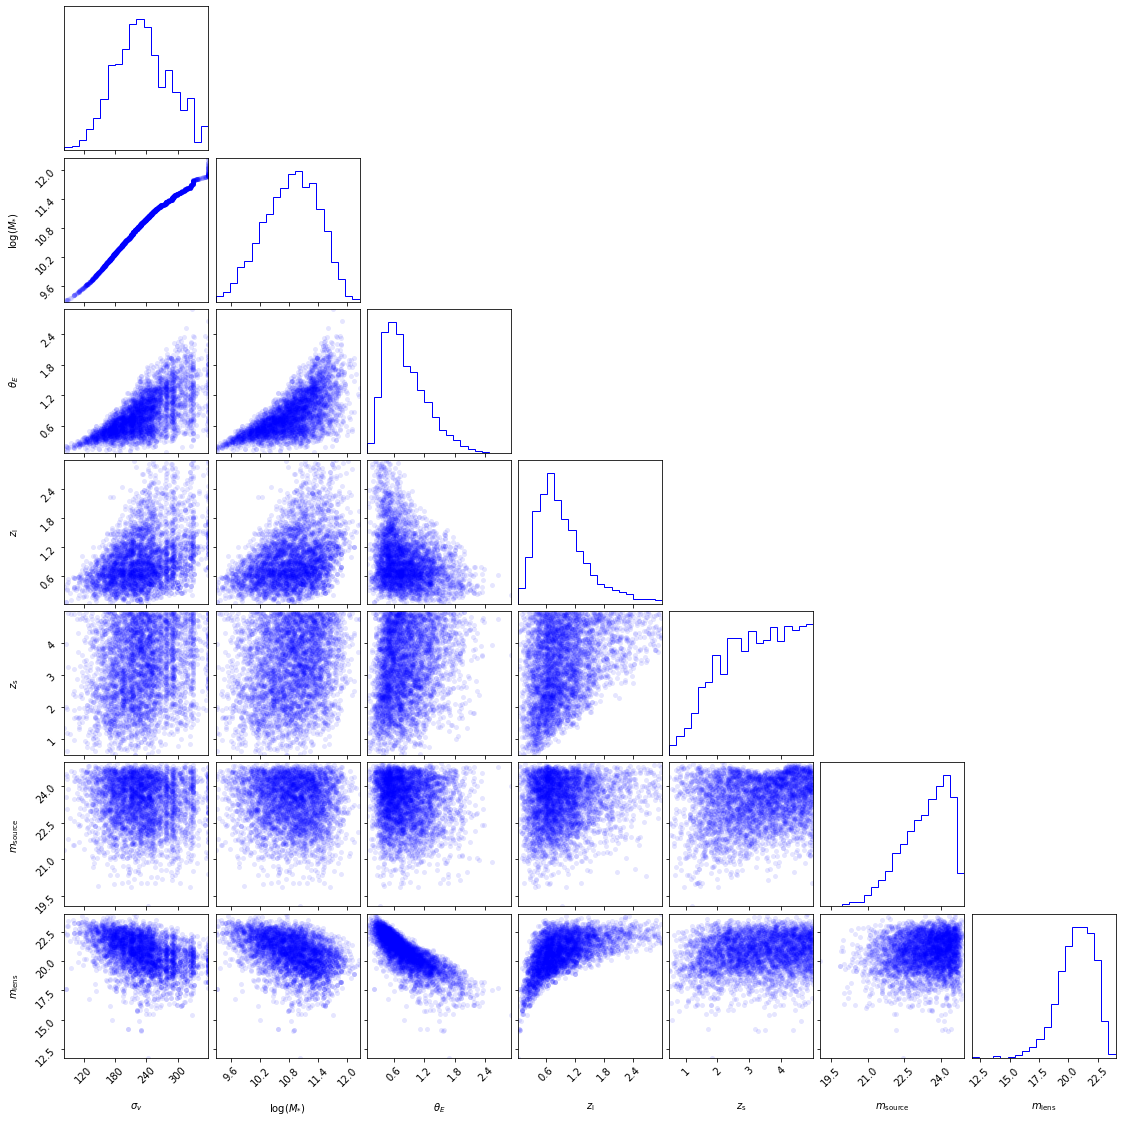

In [8]:
hist2dkwargs = {
    "plot_density": False,
    "plot_contours": False,
    "plot_datapoints": True,
    "color": "b",
    "data_kwargs": {"ms": 5},
}
corner.corner(np.array(lens_samples), labels=labels, **hist2dkwargs)
plt.show()